# **IMPORTING REQUIRED MODULES**

In [0]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys, os.path
import glob
import pickle
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import cv2
import skimage.io as io
from skimage.transform import rotate
import keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv2D,MaxPooling2D,Flatten,Dense,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import he_normal
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50,ResNet101
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

In [0]:
pip install keras_metrics

# **UNZIPPING DATA**

In [0]:
#!unzip "/content/drive/My Drive/"PROJECT.zip -d "/content/drive/My Drive/"DL_PROJECT

# **IMAGE PRE-PROCESSING**

### **PERFORMING ERROR LEVEL ANALYSIS** 

In [0]:
def ELA(path,path2,path3):
  #ref:https://gist.github.com/ewencp/3356622
  count=0
  for im in tqdm(glob.glob(path+'/*.*'),leave=True,position=0):
    if "mask" not in im:
      count=count+1
      head,tail = os.path.split(im)
      resaved = tail+'.resaved.jpg'
      ela = tail+'.ela.png'
      im = Image.open(im)
      try:
        im.save(path3+"/"+resaved,'JPEG',quality=96)
      except:
        im = im.convert('RGB')
        im.save(path3+"/"+resaved,'JPEG',quality=96)
      resaved_im = Image.open(path3+"/"+resaved)
      ela_im = ImageChops.difference(im,resaved_im)
      extrema = ela_im.getextrema()
      max_diff = max([ex[1] for ex in extrema])
      scale = 255.0/max_diff
      ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
      ela_im.save(path2+"/"+ela)
  print("\n\nPERFORMED ELA ON "+str(count)+" IMAGES")

##### **FUNCTION CALL FOR PERFORMING ELA FOR FAKE IMAGES**

In [0]:
ELA("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake","/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake_ELA","/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake_lowquality_JPG")

100%|██████████| 900/900 [15:18<00:00,  1.63s/it]



PERFORMED ELA ON 450 IMAGES


##### **FUNCTION CALL FOR PERFORMING ELA FOR REAL IMAGES**

In [0]:
ELA("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/pristine","/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/pristine_ELA","/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/pristine_lowquality_JPG")

100%|██████████| 1050/1050 [11:30<00:00,  1.47it/s]



PERFORMED ELA ON 1050 IMAGES


### **APPLYING OTHER PRE-PROCESSING TECHNIQUES (RE-SIZING,CHANNEL CONVERSION, NORMALIZATION) ON ELA PERFORMED IMAGES**

In [0]:
def image_preproc(path,class_label,count):
    img_data=pd.DataFrame(columns=["image","class"])
    proc=0
    for im in tqdm(glob.glob(path+'/*.*'),leave=True,position=0):
      proc+=1
      im = load_img(im)
      conv_img = image.img_to_array(im,data_format="channels_last"); #keeping the color-channel at the end in the representation of image vector 
      conv_img = cv2.resize(conv_img,(512,512)) ##resizing the image into the dimensions of 512x512
      try:
          conv_img= conv_img[:, :, :3] ## making all the channels to RGB if any another channel with !=3 magnitude is present
      except:
          conv_img= cv2.cvtColor(conv_img,cv2.COLOR_GRAY2RGB) #converting the grey scale images into RGB which have no channel value
      conv_img = conv_img/255 # performing the min-max normalization
      img_data.loc[count]=[conv_img,class_label]
      count=count+1
    print("\n\nPRE-PROCESSING PERFORMED ON "+str(proc)+" IMAGES")
    return img_data

##### **FUNCTION CALL FOR PERFORMING PRE-PROCESSING ON PRISTINE IMAGES**

In [0]:
original = image_preproc("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/pristine_ELA",0,0)

100%|██████████| 1050/1050 [17:38<00:00,  1.09it/s]



PRE-PROCESSING PERFORMED ON 1050 IMAGES


##### **FUNCTION CALL FOR PERFORMING PRE-PROCESSING ON FAKE IMAGES**

In [0]:
fake = image_preproc("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake_ELA",1,len(original))

100%|██████████| 450/450 [09:17<00:00,  2.68s/it]



PRE-PROCESSING PERFORMED ON 450 IMAGES


# **CONCATENATING THE PRE-PROCESSED DATA INTO A SINGLE DATAFRAME**

In [0]:
total_data = original.append(fake,ignore_index=True) ## concatenating dataframes one after the other
total_data = total_data.sample(frac=1).reset_index(drop=True) ## shuffling the data
print("SHAPE OF THE ENTIRE DATA::",total_data.shape)

SHAPE OF THE ENTIRE DATA:: (1500, 2)


# **SAMPLES PER CLASS IN THE WHOLE DATA**

In [0]:
def visualize(data,type_):
  try:
    ax = data['class'].value_counts().plot(kind='bar',grid=True)
  except:
    ax = data.value_counts().plot(kind='bar',grid=True)
  if (type_ == "train"):
    plt.title("TRAINING DATA STATISTICS")
  elif (type_=="cv"):
    plt.title("CV DATA STATISTICS")
  elif (type_=="test"):
    plt.title("TEST DATA STATISTICS")
  else:
    plt.title("COMPLETE DATA STATISTICS")
  plt.xlabel("CLASSES")
  plt.ylabel("NUMBER OF IMAGES")
  plt.xticks([0, 1], ['Pristine', 'Fake'])
  plt.show()

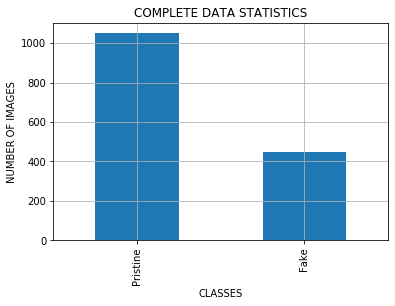

In [0]:
visualize(total_data,0)

# **TRAIN-CV-TEST SPLIT**

In [0]:
x_train, x_cv, y_train, y_cv = train_test_split(total_data['image'],total_data['class'],train_size=0.90,shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,train_size=0.75,shuffle=True)

# **SAMPLES PER CLASS IN TRAINING/CV/TEST DATASETS**

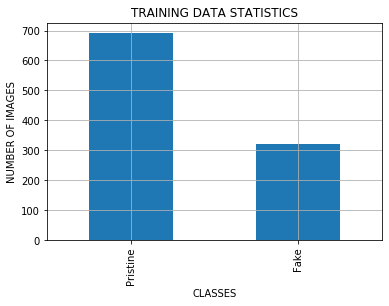

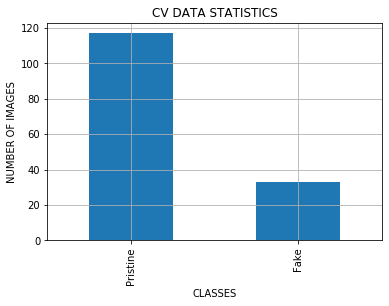

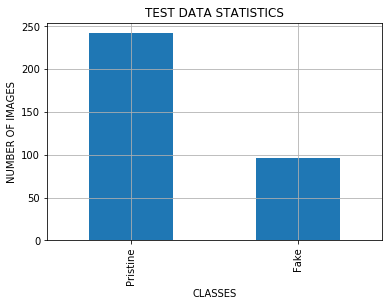

In [0]:
visualize(y_train,"train")
visualize(y_cv,"cv")
visualize(y_test,"test")

# **CONVERTING THE PANDAS DATAFRAMES INTO NUMPY ARRAYS**

In [0]:
x_train = np.array(x_train)
x_cv = np.array(x_cv)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_cv = np.array(y_cv)
y_test = np.array(y_test)
print("x_train::",x_train.shape)
print("x_cv::",x_cv.shape)
print("x_test::",x_test.shape)
print("y_train::",y_train.shape)
print("y_cv::",y_cv.shape)
print("y_test::",y_test.shape)

x_train:: (1012,)
x_cv:: (150,)
x_test:: (338,)
y_train:: (1012,)
y_cv:: (150,)
y_test:: (338,)


# **RE-SHAPING THE DATA TO SUIT THE INPUT SHAPE FOR CNNs**

In [0]:
def reshape(data,flag):
  if (flag==0):
    l=[]
    for i in data:
      l.append(i)
    l=np.array(l)
    return l
  else:
    data = keras.utils.to_categorical(data,num_classes=2)
    return data

In [0]:
x_train_cnn = reshape(x_train,0)
print("SHAPE OF X TRAIN AFTER RESHAPING::",x_train_cnn.shape)
x_cv_cnn = reshape(x_cv,0)
print("SHAPE OF X CV AFTER RESHAPING::",x_cv_cnn.shape)
x_test_cnn = reshape(x_test,0)
print("SHAPE OF X_TEST AFTER RESHAPING::",x_test_cnn.shape)
y_train_oh = reshape(y_train,1)
print("SHAPE OF Y_TRAIN AFTER ONE-HOT ENCODING::",y_train_oh.shape)
y_cv_oh = reshape(y_cv,1)
print("SHAPE OF Y_CV AFTER ONE-HOT ENCODING::",y_cv_oh.shape)
y_test_oh = reshape(y_test,1)
print("SHAPE OF Y_TEST AFTER ONE-HOT ENCODING::",y_test_oh.shape)

SHAPE OF X TRAIN AFTER RESHAPING:: (1012, 512, 512, 3)
SHAPE OF X CV AFTER RESHAPING:: (150, 512, 512, 3)
SHAPE OF X_TEST AFTER RESHAPING:: (338, 512, 512, 3)
SHAPE OF Y_TRAIN AFTER ONE-HOT ENCODING:: (1012, 2)
SHAPE OF Y_CV AFTER ONE-HOT ENCODING:: (150, 2)
SHAPE OF Y_TEST AFTER ONE-HOT ENCODING:: (338, 2)


# **CREATING PICKLE FILES OF PRE-PROCESSED TRAIN/CV/TEST DATASETS (DON'T RUN)**

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_train_cnn_DLP","wb")
#pickle.dump(x_train_cnn, pickle_out)

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_train_oh_DLP","wb")
#pickle.dump(y_train_oh,pickle_out)

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_cv_cnn_DLP","wb")
#pickle.dump(x_cv_cnn,pickle_out)

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_cv_oh_DLP","wb")
#pickle.dump(y_cv_oh,pickle_out)

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_test_cnn_DLP","wb")
#pickle.dump(x_test_cnn,pickle_out)

In [0]:
#pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_test_oh_DLP","wb")
#pickle.dump(y_test_oh,pickle_out)

# **LOADING THE PICKLE FILES OF TRAIN/CV/TEST DATASETS**

In [0]:
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_train_cnn_DLP","rb")
x_train_cnn = pickle.load(pickle_in)
print("X TRAIN LOADED..")
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_train_oh_DLP","rb")
y_train_oh = pickle.load(pickle_in)
print("Y TRAIN LOADED..")
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_cv_cnn_DLP","rb")
x_cv_cnn = pickle.load(pickle_in)
print("X CV LOADED..")
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_cv_oh_DLP","rb")
y_cv_oh = pickle.load(pickle_in)
print("Y CV LOADED..")
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_test_cnn_DLP","rb")
x_test_cnn = pickle.load(pickle_in)
print("X TEST LOADED..")
pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_test_oh_DLP","rb")
y_test_oh = pickle.load(pickle_in)
print("Y TEST LOADED..")
print("SHAPE OF X TRAIN::",x_train_cnn.shape)
print("SHAPE OF X CV::",x_cv_cnn.shape)
print("SHAPE OF X_TEST::",x_test_cnn.shape)
print("SHAPE OF Y_TRAIN::",y_train_oh.shape)
print("SHAPE OF Y_CV::",y_cv_oh.shape)
print("SHAPE OF Y_TEST::",y_test_oh.shape)

X TRAIN LOADED..
Y TRAIN LOADED..
X CV LOADED..
Y CV LOADED..
X TEST LOADED..
Y TEST LOADED..
SHAPE OF X TRAIN:: (1012, 512, 512, 3)
SHAPE OF X CV:: (150, 512, 512, 3)
SHAPE OF X_TEST:: (338, 512, 512, 3)
SHAPE OF Y_TRAIN:: (1012, 2)
SHAPE OF Y_CV:: (150, 2)
SHAPE OF Y_TEST:: (338, 2)


# **RESHAPING THE DATA TO SUIT MLP INPUT SHAPE**

In [0]:
l_train=[]
l_cv=[]
l_test=[]
for i in x_train:
  l_train.append(i.flatten())
l_train = np.array(l_train)
for j in x_cv:
  l_cv.append(j.flatten())
l_cv = np.array(l_cv)
for k in x_test:
  l_test.append(k.flatten())
l_test = np.array(l_test)
print(l_train.shape,l_cv.shape,l_test.shape)

(1012, 786432) (150, 786432) (338, 786432)


# **TRAINING A MLP WITHOUT ANY DATA AUGMENTATION** 

In [0]:
#ref:https://keras.io/examples/mnist_mlp/
import keras_metrics
mlp = Sequential()## defining a sequential model
mlp.add(Dense(150, activation='relu',input_shape=(786432,),kernel_initializer='he_normal'))
mlp.add(Dropout(0.2)) 
mlp.add(Dense(50, activation='relu',kernel_initializer='he_normal'))
mlp.add(Dropout(0.2)) 
mlp.add(Dense(10, activation='relu',kernel_initializer='he_normal'))
mlp.add(Dropout(0.2)) 
mlp.add(Dense(10, activation='relu',kernel_initializer='he_normal')) 
mlp.add(BatchNormalization()) 
mlp.add(Dense(2, activation='softmax')) 
mlp.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001),metrics=([keras_metrics.binary_f1_score()])) 
values_mlp = mlp.fit(l_train,y_train,batch_size=25,epochs=10,validation_data=(l_cv,y_cv))

Train on 1012 samples, validate on 150 samples
Epoch 1/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.8595 - f1_score: 0.6163 - val_loss: 0.6386 - val_f1_score: 0.8327
Epoch 2/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.8053 - f1_score: 0.6185 - val_loss: 0.7295 - val_f1_score: 0.5371
Epoch 3/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.7638 - f1_score: 0.6020 - val_loss: 0.7304 - val_f1_score: 0.5287
Epoch 4/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.7648 - f1_score: 0.5879 - val_loss: 0.7054 - val_f1_score: 0.5761
Epoch 5/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.7699 - f1_score: 0.6164 - val_loss: 0.7011 - val_f1_score: 0.6032
Epoch 6/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.7464 - f1_score: 0.6585 - val_loss: 0.6985 - val_f1_score: 0.6105
Epoch 7/10
1012/1012 [==============================] - 4s 4ms/step - loss: 0.7452 - f1_s

## **CONFUSION MATRIX WITH MLP**

In [0]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), mlp.predict_classes(l_test))#y_pred.argmax(axis=1))
print(matrix)

[[115 117]
 [ 55  51]]


## **PERFORMANCE WITH MLP**

In [0]:
scores_train_mlp = mlp.evaluate(l_train,y_train)
print("TRAIN F1-SCORE WITH MLP::",scores_train_mlp[1])
print("TRAINING LOSS WITH MLP::",scores_train_mlp[0])
scores_cv_mlp = mlp.evaluate(l_cv,y_cv)
print("CV F1-SCORE WITH MLP::",scores_cv_mlp[1])
print("CV LOSS WITH MLP::",scores_cv_mlp[0])
scores_test_mlp = mlp.evaluate(l_test,y_test)
print("TEST F1-SCORE WITH MLP::",scores_test_mlp[1])
print("TEST LOSS WITH MLP::",scores_test_mlp[0])

1012/1012 [==============================] - 2s 2ms/step
TRAIN F1-SCORE WITH MLP:: 0.6328699429393999
TRAINING LOSS WITH MLP:: 0.6719356721097772
150/150 [==============================] - 0s 2ms/step
CV F1-SCORE WITH MLP:: 0.5745855872897693
CV LOSS WITH MLP:: 0.7123670164744059
338/338 [==============================] - 1s 2ms/step
TEST F1-SCORE WITH MLP:: 0.5721392543872719
TEST LOSS WITH MLP:: 0.6864882436024367


## **EPOCHS VS F1-SCORE WITH MLP**

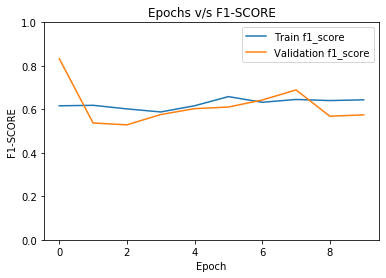

In [0]:
plt.plot(values_mlp.history['f1_score'])
plt.plot(values_mlp.history['val_f1_score'])
plt.title('Epochs v/s F1-SCORE')
plt.xlabel('Epoch')
plt.ylabel('F1-SCORE')
plt.ylim([0,1])
plt.legend(['Train f1_score','Validation f1_score'])
plt.show()

## **EPOCHS VS LOSS WITH MLP**

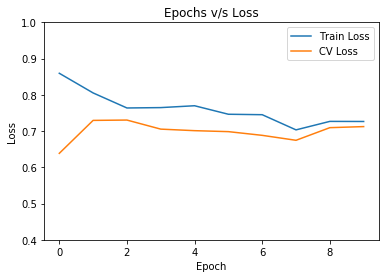

In [0]:
plt.plot(values_mlp.history['loss'])
plt.plot(values_mlp.history['val_loss'])
plt.title('Epochs v/s Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.4,1])
plt.legend(['Train Loss', 'CV Loss'])
plt.show()

## **RESULTS::**
### **TRAINING LOSS:0.671**
### **TRAINING F1-SCORE:0.632**
### **VALIDATION LOSS: 0.712**
### **VALIDATION F1-SCORE: 0.574**
### **TEST LOSS:0.686**
### **TEST F1-SCORE:0.572**

# **PERFORMING DATA AUGMENTATION**

In [0]:
#ref:https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
x_train_aug = []
y_train_aug = []
from skimage.transform import AffineTransform,warp
transform = AffineTransform(translation=(25,25))
for i in tqdm(range(x_train_cnn.shape[0]),leave=True,position=0):
  if(y_train_oh[i]==[1,0]).all():
      x_train_aug.append(x_train_cnn[i]) ## original image
      x_train_aug.append(np.fliplr(x_train_cnn[i])) ## mirror image
      x_train_aug.append(np.flipud(x_train_cnn[i])) ## upside down
      for j in range(3):
          y_train_aug.append(y_train_oh[i])
  if(y_train_oh[i]==[0,1]).all():
      x_train_aug.append(x_train_cnn[i]) ## original image
      x_train_aug.append(rotate(x_train_cnn[i], angle=45)) ## rotation
      x_train_aug.append(np.fliplr(x_train_cnn[i])) ## mirror image
      x_train_aug.append(np.flipud(x_train_cnn[i])) ## upside down
      x_train_aug.append(warp(x_train_cnn[i],transform))
      for j in range(5):
          y_train_aug.append(y_train_oh[i])
x_train_aug = np.asarray(x_train_aug)
y_train_aug_oh = np.asarray(y_train_aug)

100%|██████████| 1012/1012 [00:13<00:00, 77.10it/s]


In [0]:
print("\nSIZE OF X_TRAIN BEFORE DATA AUGMENTATION::",x_train_cnn.shape)
print("\nSIZE OF Y_TRAIN BEFORE DATA AUGMENTATION::",y_train_oh.shape)
print("\nSIZE OF X_TRAIN AFTER DATA AUGMENTATION::",x_train_aug.shape)
print("\nSIZE OF Y_TRAIN AFTER DATA AUGMENTATION::",y_train_aug_oh.shape)


SIZE OF X_TRAIN BEFORE DATA AUGMENTATION:: (1012, 512, 512, 3)

SIZE OF Y_TRAIN BEFORE DATA AUGMENTATION:: (1012, 2)

SIZE OF X_TRAIN AFTER DATA AUGMENTATION:: (3634, 512, 512, 3)

SIZE OF Y_TRAIN AFTER DATA AUGMENTATION:: (3634, 2)


# **CREATING PICKLE FILES FOR AUGMENTED DATA**

In [0]:
'''pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_train_aug_DLP","wb")
pickle.dump(x_train_aug,pickle_out)'''

In [0]:
'''pickle_out = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_train_aug_oh_DLP","wb")
pickle.dump(y_train_aug_oh,pickle_out)'''

# **LOADING PICKLE FILES OF AUGMENTED DATA**

In [0]:
'''pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/x_train_aug_DLP","rb")
x_train_aug = pickle.load(pickle_in)
print("SHAPE OF X-TRAIN AUGMENTED::",x_train_aug.shape)'''

In [0]:
'''pickle_in = open("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/y_train_aug_oh_DLP","rb")
y_train_aug_oh = pickle.load(pickle_in)
print("SHAPE OF Y-TRAIN AUGMENTED::",y_train_aug_oh.shape)'''

# **TRAINING DATA STATISTICS AFTER DATA AUGMENTATION**

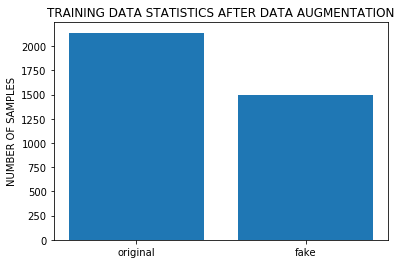

COUNT OF ORIGINAL IMAGES AFTER DATA AUGMENTATION:: 2139
COUNT OF FAKE IMAGES AFTER DATA AUGMENTATION:: 1495


In [0]:
lab={}
lab['original']=0
lab['fake']=0
for i in y_train_aug_oh:
  if (i==np.array([1,0])).all():
    lab['original']+=1
  elif(i==np.array([0,1])).all():
    lab['fake']+=1
x = ['original','fake'] 
y = [lab['original'],lab['fake']] 
plt.bar(x, y, align = 'center') 
plt.title('TRAINING DATA STATISTICS AFTER DATA AUGMENTATION') 
plt.ylabel('NUMBER OF SAMPLES') 
plt.show()
print("COUNT OF ORIGINAL IMAGES AFTER DATA AUGMENTATION::",lab['original'])
print("COUNT OF FAKE IMAGES AFTER DATA AUGMENTATION::",lab['fake'])

# **TRAINING A CNN ARCHITECTURE WITH DATA AUGMENTATION**

In [0]:
import keras_metrics
model_cnn = Sequential() 
model_cnn.add(Conv2D(16, kernel_size =(3, 3), strides =(1, 1),activation ='relu',input_shape=(512,512,3),kernel_initializer='he_normal'))
model_cnn.add(MaxPooling2D(pool_size =(2, 2), strides =2))
model_cnn.add(Conv2D(16, kernel_size =(3, 3), strides =(1, 1),activation ='relu',input_shape=(512,512,3),kernel_initializer='he_normal'))
model_cnn.add(MaxPooling2D(pool_size =(2, 2), strides =2))
model_cnn.add(Dropout(0.4)) 
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation ='relu',kernel_initializer='he_normal'))
model_cnn.add(Dropout(0.4)) 
model_cnn.add(Dense(2, activation ='softmax'))
model_cnn.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(lr = 0.00015),metrics=([keras_metrics.binary_f1_score()]))
values_cnn = model_cnn.fit(x_train_aug,y_train_aug_oh,batch_size=25,epochs=6,validation_data =(x_cv_cnn,y_cv_oh))

Train on 3634 samples, validate on 150 samples
Epoch 1/6
3634/3634 [==============================] - 13s 4ms/step - loss: 0.6063 - f1_score: 0.7753 - val_loss: 0.6008 - val_f1_score: 0.8480
Epoch 2/6
3634/3634 [==============================] - 12s 3ms/step - loss: 0.5072 - f1_score: 0.8307 - val_loss: 0.6237 - val_f1_score: 0.8201
Epoch 3/6
3634/3634 [==============================] - 12s 3ms/step - loss: 0.4710 - f1_score: 0.8403 - val_loss: 0.5442 - val_f1_score: 0.8502
Epoch 4/6
3634/3634 [==============================] - 12s 3ms/step - loss: 0.4309 - f1_score: 0.8525 - val_loss: 0.5984 - val_f1_score: 0.8525
Epoch 5/6
3634/3634 [==============================] - 12s 3ms/step - loss: 0.4102 - f1_score: 0.8571 - val_loss: 0.5758 - val_f1_score: 0.8477
Epoch 6/6
3634/3634 [==============================] - 12s 3ms/step - loss: 0.3845 - f1_score: 0.8644 - val_loss: 0.5686 - val_f1_score: 0.8477


# **CONFUSION MATRIX ON TEST DATA WITH CNN ARCHITECTURE**

In [0]:
matrix = metrics.confusion_matrix(y_test_oh.argmax(axis=1), model_cnn.predict_classes(x_test_cnn))
print(matrix)

[[219  11]
 [ 76  32]]


# **SAVING THE CNN MODEL**

In [0]:
model_cnn.save("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/cnn_model_phase_1.h5") 

# **PERFORMANCE ON THE TEST DATA WITH CNN ARCHITECTURE**

In [0]:
model_cnn.evaluate(x_test_cnn,y_test_oh)

338/338 [==============================] - 1s 2ms/step


[0.5353443195833962, 0.8342856647343341]

## **EPOCHS V/S F1-SCORE WITH CNN ARCHITECTURE**


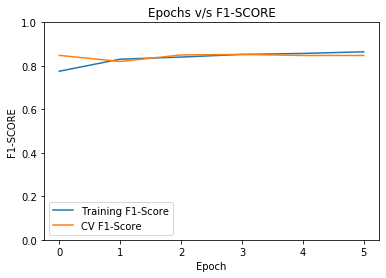

In [0]:
plt.plot(values_cnn.history['f1_score'])
plt.plot(values_cnn.history['val_f1_score'])
plt.title('Epochs v/s F1-SCORE')
plt.xlabel('Epoch')
plt.ylabel('F1-SCORE')
plt.ylim([0,1])
plt.legend(['Training F1-Score', 'CV F1-Score'])
plt.show()

## **EPOCHS V/S LOSS WITH CNN ARCHITECTURE**

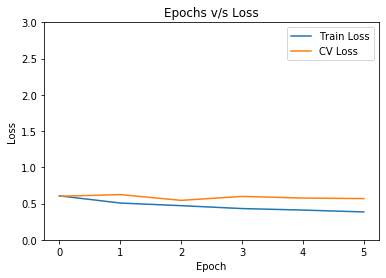

In [0]:
plt.plot(values_cnn.history['loss'])
plt.plot(values_cnn.history['val_loss'])
plt.title('Epochs v/s Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,3])
plt.legend(['Train Loss', 'CV Loss'])
plt.show()

## **RESULTS USING CNN ARCHITECTURE::**
### **TRAINING LOSS:0.3845**
### **TRAINING F1-Score:0.8644**
### **VALIDATION LOSS:0.5686**
### **VALIDATION F1-Score:0.8477**
### **TEST LOSS:0.5353**
### **TEST F1-Score:0.8342**


# **USING TRANSFER LEARNING**

### **USING PRE-TRAINED RESNET-50 ARCHITECTURE WITH DATA AUGMENTATION**




In [0]:
import keras_metrics
resnet_50 = ResNet50(include_top=False, weights='imagenet',input_shape=(512,512,3))

In [0]:
model_resnet50=Sequential()
model_resnet50.add(resnet_50)
top_model=Sequential()
top_model.add(Flatten(input_shape=(16,16,2048)))
top_model.add(Dropout(0.7))
top_model.add(BatchNormalization())
top_model.add(Dense(2, activation='softmax'))
model_resnet50.add(top_model)
for layer in model_resnet50.layers[0].layers[:174]:
    layer.trainable=False
model_resnet50.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001),metrics=([keras_metrics.binary_f1_score()]))
values_resnet50=model_resnet50.fit(x_train_aug,y_train_aug_oh,batch_size=25,epochs=5,validation_data =(x_cv_cnn,y_cv_oh))

Train on 3634 samples, validate on 150 samples
Epoch 1/5
3634/3634 [==============================] - 43s 12ms/step - loss: 2.6242 - f1_score: 0.7964 - val_loss: 3.8469 - val_f1_score: 0.8136
Epoch 2/5
3634/3634 [==============================] - 39s 11ms/step - loss: 2.0745 - f1_score: 0.8667 - val_loss: 3.7060 - val_f1_score: 0.7798
Epoch 3/5
3634/3634 [==============================] - 39s 11ms/step - loss: 1.9756 - f1_score: 0.8766 - val_loss: 3.8156 - val_f1_score: 0.8382
Epoch 4/5
3634/3634 [==============================] - 39s 11ms/step - loss: 1.8017 - f1_score: 0.8905 - val_loss: 4.1551 - val_f1_score: 0.7890
Epoch 5/5
3634/3634 [==============================] - 39s 11ms/step - loss: 1.6538 - f1_score: 0.8968 - val_loss: 4.1459 - val_f1_score: 0.8250


# **CONFUSION MATRIX WITH PRE-TRAINED RESNET-50** 

In [0]:
matrix = metrics.confusion_matrix(y_test_oh.argmax(axis=1), model_resnet50.predict_classes(x_test_cnn))
print(matrix)

[[210  20]
 [ 65  43]]


# **SAVING THE PRE-TRAINED RESNET-50 MODEL**

In [0]:
model_resnet50.save("/content/drive/My Drive/DL_PROJECT/PROJECT/DL_PROJECT_DATA/resnet_model_phase_1.h5") 

# **PERFORMANCE ON THE TEST DATA WITH PRE-TRAINED RESNET-50**

In [0]:
model_resnet50.evaluate(x_test_cnn,y_test_oh)

338/338 [==============================] - 4s 11ms/step


[3.5203481284824347, 0.8316831183844752]

# **EPOCHS V/S F1-SCORE PLOT WITH PRE-TRAINED RESNET-50**

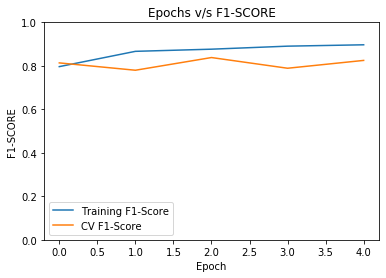

In [0]:
plt.plot(values_resnet50.history['f1_score'])
plt.plot(values_resnet50.history['val_f1_score'])
plt.title('Epochs v/s F1-SCORE')
plt.xlabel('Epoch')
plt.ylabel('F1-SCORE')
plt.ylim([0,1])
plt.legend(['Training F1-Score', 'CV F1-Score'])
plt.show()

# **EPOCHS V/S LOSS PLOT WITH PRE-TRAINED RESNET-50**

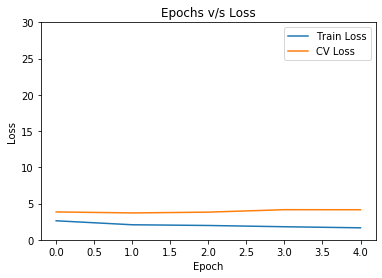

In [0]:
plt.plot(values_resnet50.history['loss'])
plt.plot(values_resnet50.history['val_loss'])
plt.title('Epochs v/s Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,30])
plt.legend(['Train Loss', 'CV Loss'])
plt.show()

## **RESULTS USING PRE-TRAINED RESNET-50 ARCHITECTURE::**
### **TRAINING LOSS:1.6538**
### **TRAINING F1-Score:0.8968**
### **VALIDATION LOSS:3.1459**
### **VALIDATION F1-Score:0.8250**
### **TEST LOSS:3.5203**
### **TEST F1-Score:0.8316**




## **CODE TO REMOVE NON-EMPTY FOLDER IN GOOGLE COLAB**

In [0]:
import shutil
shutil.rmtree('/content/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake_ELA')
shutil.rmtree('/content/DL_PROJECT/PROJECT/DL_PROJECT_DATA/fake_lowquality_JPG')